In [1]:
#%load_ext autoreload
#%autoreload 2
import os
#os.environ["CUDA_VISIBLE_DEVICES"]=""

import pandas as pd
import numpy as np
import os, gc

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
from os.path import getsize

from fastai import *
from fastai.basic_train import *
from fastai.basic_data import *
from fastai.data_block import *
from fastai.torch_core import *
from fastai.train import *
from fastai.callback import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.layers import *
from fastai.text import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [2]:
#Experiments

VAE = True #If false it uses a plain autoencoder
CCLE_scaler = MinMaxScaler() #StandardScaler() #DummyScaler()#
TCGA_scaler = MinMaxScaler() #StandardScaler() #DummyScaler()#

autoencoder_fname = "VAE_loss2216964.0000val0.0764" #autoencoder_loss0.2517val0.5788" # "VAE_loss2216964.0000val0.0764" #uncomment or set None to skip loading trained net
train_autoencoder = False #if not train autoencoder and autoencoder_fname is none then drug-predictors uses a non-pretrained autoencoder 





In [3]:
def try_read_feather(fn, **kwargs):
    fn_feather = fn.replace('.csv','.feather')
    if os.path.exists(fn_feather):
        df = pd.read_feather(fn_feather)
        df.set_index('index', inplace=True)
        del df.index.name
        return df
    df = pd.read_csv(fn,**kwargs)
    df.reset_index().to_feather(fn_feather)
    return df

In [4]:

E_CCLE = try_read_feather('E_CCLE.csv', index_col=0)
M_CCLE = try_read_feather('M_CCLE.csv', index_col=0)


In [5]:
E_TCGA = try_read_feather('E_TCGA.csv',index_col=0)
E_TCGA.head()

,d3b7ada6-5395-4212-a921-8e97c92b605d,065f7b7a-05ee-4728-bcfc-6095357512a6,065f7b7a-05ee-4728-bcfc-6095357512a6.1,c328f661-c109-4e01-b819-299a75bd4348,ebe927e6-0a7e-4c97-ad73-f3c302cca7bc,c739fd61-22b2-412d-bcf3-89bda45a2c0f,a7fd6522-8953-461f-9e5f-fdeb7d180d46,75fb484d-cd12-4cf0-a99d-faf27aead118,86d1e388-b30f-48fd-9647-3848eb6134f1,2b715eb2-055e-4bc5-bc98-128e8bf6954f,...,4dc5cffe-ed8c-47ab-b5fc-f9615b5414f7,40551d53-388b-4067-9341-76e94d023703,0775583e-c0a0-4f18-9ca2-8f89cedce3d6,e76cf9a0-061e-4a7d-ba28-5a40b8da54b8,5166d82f-7b22-4101-bea9-6056e5a74c48,5cf3911a-f3ea-4c0e-851d-5bb57ca7190f,aaacf22c-2362-4613-b024-88fb7dd1cca1,95b69517-4971-450e-9ed0-43bc8b2c0534,b4f7f9e4-5fc5-4461-8e0b-0b6c384863c6,180a2b9c-9cac-4d96-86e8-cd6b3b9386b5
ZBTB7A,4.256269,3.670214,4.084939,3.058325,3.124356,2.467282,3.095970,2.833903,2.375767,3.340601,...,3.444930,3.781334,4.207886,3.982777,4.264515,3.600509,3.755943,3.927952,4.088327,3.333482
CRH,0.000000,0.028710,0.000000,0.000000,0.000000,0.000000,0.014498,4.895267,0.226636,0.000000,...,4.620040,0.378614,0.000000,0.000000,0.000000,0.000000,0.028710,0.000000,0.000000,0.000000
TMEM74B,0.722542,4.086634,3.150595,1.232706,2.634650,0.310455,1.042702,2.662223,0.871913,1.448950,...,2.887547,2.378513,1.406022,1.871906,3.753813,1.448950,1.659971,2.173173,2.229609,0.660012
ERLIN2,4.252478,3.344838,3.671320,5.463052,4.100191,4.552759,4.194551,4.848518,3.925056,3.371554,...,3.657686,5.479670,4.541655,4.147325,5.295769,3.962552,4.372235,4.416812,3.569248,3.181076
ZBTB43,2.521083,2.508458,2.963452,2.702668,1.546046,1.786659,1.918422,2.835967,1.459497,1.691585,...,2.715885,2.763422,2.310397,1.835943,3.390993,1.922249,1.731194,1.844018,1.875834,1.937373


In [6]:
M_TCGA = try_read_feather('M_TCGA.csv',index_col=0)

In [7]:
IC50 = try_read_feather('IC50_CCLE_author.csv',index_col=0)

In [8]:
M_sco_TCGA = try_read_feather('M_scored_TCGA.csv',index_col=0)
M_sco_CCLE = try_read_feather('M_scored_CCLE.csv',index_col=0)

In [9]:
E_CCLE = E_CCLE.transpose()
E_CCLE.head()

,ZBTB7A,CRH,TMEM74B,ERLIN2,ZBTB43,POLL,SPANXN1,CPNE7,OR8B3,PKHD1L1,...,C11orf87,CUEDC2,ZNF799,FOXR1,BMPER,LAMA1,EPS15,GSC2,TP53BP1,MGAM
NIHOVCAR3,2.765535,0.163499,0.863938,4.254745,3.235727,4.941576,0.0,0.925999,0.0,0.189034,...,0.014355,6.524346,0.879706,0.000000,4.386121,4.013462,4.094236,0.042644,5.428611,0.042644
HL60,2.250962,0.176323,0.042644,2.521051,1.613532,4.323370,0.0,0.097611,0.0,0.000000,...,0.000000,5.744430,1.570463,0.000000,0.137504,0.084064,3.267536,0.000000,3.026800,0.748461
CACO2,2.063503,0.056584,2.467279,4.303781,2.430285,3.713696,0.0,4.270529,0.0,0.000000,...,0.014355,4.603478,2.189034,0.000000,0.356144,2.887525,3.612352,0.000000,3.807355,0.356144
HEL,2.490570,0.000000,1.454176,4.211791,2.384050,4.375039,0.0,0.084064,0.0,0.014355,...,0.028569,6.476058,1.214125,0.028569,0.056584,0.014355,5.934752,0.000000,4.384741,0.422233
HEL9217,2.232661,0.028569,1.063503,4.180307,2.427606,4.207893,0.0,0.432959,0.0,0.000000,...,0.014355,6.458284,1.811471,0.000000,0.111031,0.014355,6.020147,0.000000,4.958379,0.584963


In [10]:
M_CCLE = M_CCLE.transpose()
M_CCLE.head()

,ZBTB7A,CRH,TMEM74B,ERLIN2,ZBTB43,POLL,SPANXN1,CPNE7,OR8B3,PKHD1L1,...,C11orf87,CUEDC2,ZNF799,FOXR1,BMPER,LAMA1,EPS15,GSC2,TP53BP1,MGAM
127399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22RV1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
2313287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,2.0
253J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
M_TCGA = M_TCGA.transpose()
M_TCGA.head()

,ZBTB7A,CRH,TMEM74B,ERLIN2,ZBTB43,POLL,SPANXN1,CPNE7,OR8B3,PKHD1L1,...,C11orf87,CUEDC2,ZNF799,FOXR1,BMPER,LAMA1,EPS15,GSC2,TP53BP1,MGAM
0004d251-3f70-4395-b175-c94c2f5b1b81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000d566c-96c7-4f1c-b36e-fa2222467983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011a67b-1ba9-4a32-a6b8-7850759a38cf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001887aa-36d0-463f-8bca-dec7043b4f2e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001944e5-af34-4061-9c09-bb9ea346f6fd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
E_TCGA = E_TCGA.transpose()
E_TCGA.head()

,ZBTB7A,CRH,TMEM74B,ERLIN2,ZBTB43,POLL,SPANXN1,CPNE7,OR8B3,PKHD1L1,...,C11orf87,CUEDC2,ZNF799,FOXR1,BMPER,LAMA1,EPS15,GSC2,TP53BP1,MGAM
d3b7ada6-5395-4212-a921-8e97c92b605d,4.256269,0.00000,0.722542,4.252478,2.521083,4.249446,0.000000,5.136277,0.0,0.201757,...,0.042784,5.354371,2.513489,0.00000,0.356247,1.131011,3.682567,0.0,3.874763,0.124460
065f7b7a-05ee-4728-bcfc-6095357512a6,3.670214,0.02871,4.086634,3.344838,2.508458,5.236450,0.000000,0.150686,0.0,0.956147,...,0.028710,6.134662,1.495726,0.00000,1.922249,0.201757,3.712564,0.0,4.603446,0.111167
065f7b7a-05ee-4728-bcfc-6095357512a6.1,4.084939,0.00000,3.150595,3.671320,2.963452,5.499225,0.000000,0.111167,0.0,0.433055,...,0.000000,6.549867,1.541050,0.00000,2.025058,0.992862,4.061800,0.0,4.644992,0.111167
c328f661-c109-4e01-b819-299a75bd4348,3.058325,0.00000,1.232706,5.463052,2.702668,4.407376,0.056724,0.632353,0.0,7.565331,...,2.241900,6.042239,1.275063,0.02871,0.555915,2.877778,4.200036,0.0,4.368048,0.000000
ebe927e6-0a7e-4c97-ad73-f3c302cca7bc,3.124356,0.00000,2.634650,4.100191,1.546046,4.803753,0.124460,3.927952,0.0,4.020564,...,0.014498,6.548086,2.153826,0.00000,0.632353,3.662199,3.561924,0.0,3.488046,0.298782


In [18]:
import requests
import json
import io


sample_query = list(E_TCGA.index)[:]

cases_endpt = 'https://api.gdc.cancer.gov/cases'

# The 'fields' parameter is passed as a comma-separated string of single names.
## Available fields: https://docs.gdc.cancer.gov/API/Users_Guide/Appendix_A_Available_Fields/
fields = [
    "submitter_id",
    "case_id",
    "primary_site",
    "disease_type",
    "diagnoses.age_at_diagnosis",
    "demographic.gender",
    "files.cases.samples.sample_type"
    ]

fields = ','.join(fields)

filters = {
    "op": "in",
    "content":{
        "field": "case_id",
        "value": sample_query
        }
    }

# With a GET request, the filters parameter needs to be converted
# from a dictionary to JSON-formatted string


params = {
    "filters": json.dumps(filters),
    "fields": fields,
    "format": "TSV",
    "size": "20000"
    }

#response = requests.get(cases_endpt, params = params)

response = requests.post(cases_endpt,
                        data = json.dumps(params),
                        headers={
                            "Content-Type": "application/json"
                            })



meta = pd.read_csv(io.StringIO(response.content.decode('utf-8')), sep='\t', header=0, index_col = 'case_id')
meta.index.name = "index"
meta.reset_index().to_feather("TCGA_clinical_data.feather")
_m = try_read_feather('TCGA_clinical_data.feather', index_col=0)
_m

,diagnoses.0.age_at_diagnosis,disease_type,primary_site,id,demographic.gender,submitter_id
787c3e2f-a708-4985-a5b1-b2383c7bfc52,23042.0,"Cystic, Mucinous and Serous Neoplasms",Corpus uteri,787c3e2f-a708-4985-a5b1-b2383c7bfc52,female,TCGA-FI-A2EY
ea1c693d-490d-4816-b6e3-d12946ad7cc1,30095.0,"Cystic, Mucinous and Serous Neoplasms",Corpus uteri,ea1c693d-490d-4816-b6e3-d12946ad7cc1,female,TCGA-EY-A210
9ee944ef-4293-4228-b750-cc34ab388eb3,28559.0,"Cystic, Mucinous and Serous Neoplasms",Corpus uteri,9ee944ef-4293-4228-b750-cc34ab388eb3,female,TCGA-AJ-A3TW
ab7adf74-6e87-4117-9742-54e323348e06,26002.0,"Cystic, Mucinous and Serous Neoplasms",Corpus uteri,ab7adf74-6e87-4117-9742-54e323348e06,female,TCGA-BK-A26L
43e08773-767e-4b81-94e4-8848565c23e9,23554.0,Adenomas and Adenocarcinomas,Corpus uteri,43e08773-767e-4b81-94e4-8848565c23e9,female,TCGA-AJ-A8CW
10eb7dfa-d43d-479f-8c46-c0424207f958,13245.0,Adenomas and Adenocarcinomas,Corpus uteri,10eb7dfa-d43d-479f-8c46-c0424207f958,female,TCGA-EO-A22X
2cf8de9f-b305-4d98-bfd4-33377bf6138f,23162.0,"Cystic, Mucinous and Serous Neoplasms",Corpus uteri,2cf8de9f-b305-4d98-bfd4-33377bf6138f,female,TCGA-EO-A3B1
139e2c5a-cc0c-43a2-b30e-b8ac17c0b5f2,27221.0,Adenomas and Adenocarcinomas,Corpus uteri,139e2c5a-cc0c-43a2-b30e-b8ac17c0b5f2,female,TCGA-B5-A3FH
b1b9173c-b370-4fe5-a263-c807e8a9709c,27104.0,Adenomas and Adenocarcinomas,Corpus uteri,b1b9173c-b370-4fe5-a263-c807e8a9709c,female,TCGA-PG-A917
cf77afe9-3785-45d4-ba2a-61c9cb706225,28057.0,Adenomas and Adenocarcinomas,Corpus uteri,cf77afe9-3785-45d4-ba2a-61c9cb706225,female,TCGA-A5-A2K5


In [28]:
print(_m.shape)
len(set(E_TCGA.index) - set(_m[["id"]]))
Cx_E_TCGA = _m.join(E_TCGA)
Cx_E_TCGA.head()



(9255, 6)


,diagnoses.0.age_at_diagnosis,disease_type,primary_site,id,demographic.gender,submitter_id,ZBTB7A,CRH,TMEM74B,ERLIN2,...,C11orf87,CUEDC2,ZNF799,FOXR1,BMPER,LAMA1,EPS15,GSC2,TP53BP1,MGAM
787c3e2f-a708-4985-a5b1-b2383c7bfc52,23042.0,"Cystic, Mucinous and Serous Neoplasms",Corpus uteri,787c3e2f-a708-4985-a5b1-b2383c7bfc52,female,TCGA-FI-A2EY,2.039190,0.000000,1.182776,1.207974,...,0.000000,5.433641,0.815671,0.000000,0.014498,2.843969,1.669079,0.0,2.528603,0.014498
ea1c693d-490d-4816-b6e3-d12946ad7cc1,30095.0,"Cystic, Mucinous and Serous Neoplasms",Corpus uteri,ea1c693d-490d-4816-b6e3-d12946ad7cc1,female,TCGA-EY-A210,2.618221,0.014498,2.735580,2.929767,...,0.000000,7.224173,0.956147,0.028710,0.251076,5.471165,3.342043,0.0,3.368754,0.275124
9ee944ef-4293-4228-b750-cc34ab388eb3,28559.0,"Cystic, Mucinous and Serous Neoplasms",Corpus uteri,9ee944ef-4293-4228-b750-cc34ab388eb3,female,TCGA-AJ-A3TW,2.342028,0.000000,0.495795,2.427665,...,0.000000,5.758377,1.448950,0.000000,0.000000,4.260060,2.799147,0.0,4.082398,0.111167
ab7adf74-6e87-4117-9742-54e323348e06,26002.0,"Cystic, Mucinous and Serous Neoplasms",Corpus uteri,ab7adf74-6e87-4117-9742-54e323348e06,female,TCGA-BK-A26L,1.195401,0.000000,0.416952,4.048349,...,0.400658,3.635179,1.807400,0.000000,1.073882,3.775597,4.369158,0.0,4.564695,0.189164
43e08773-767e-4b81-94e4-8848565c23e9,23554.0,Adenomas and Adenocarcinomas,Corpus uteri,43e08773-767e-4b81-94e4-8848565c23e9,female,TCGA-AJ-A8CW,3.176361,0.000000,0.464783,4.440270,...,0.000000,6.400366,2.813548,0.042784,0.111167,4.346264,3.724670,0.0,4.159501,0.176446


In [13]:
IC50 = IC50.transpose()
print(IC50.shape)
IC50.describe() #(samples, drugs)


(622, 265)


,TL-2-105,TAK-715,CP466722,BMS-345541,Genentech_Cpd_10,GSK429286A,Ruxolitinib,SB-715992,ZSTK474,KIN001-102,...,SalubriNaN,Dasatinib,XMD8-85,Roscovitine,Lapatinib,Cyclopamine,VX-680,JW-7-52-1,Erlotinib,Rapamycin
count,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,...,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000
mean,3.851825,4.179568,2.648195,3.096796,2.564194,4.775895,3.988149,-1.681601,1.064734,2.600120,...,4.134092,2.308223,3.609585,4.296905,3.472246,4.618005,2.561507,1.268788,3.504453,1.162873
std,1.348962,1.163468,1.357494,1.189023,1.730623,1.196296,0.957125,1.766192,1.621243,1.477692,...,1.104377,2.298384,1.309004,1.047221,1.284756,0.982353,1.933500,2.665416,1.340374,3.156771
min,-3.300900,0.337790,-1.559500,-1.281300,-2.080500,-1.231900,-3.894000,-5.881400,-4.795500,-1.946800,...,0.805350,-6.875200,-0.555480,1.608963,-3.465800,1.614506,-4.120200,-4.962900,-3.128400,-8.740200
25%,3.179982,3.374443,1.770300,2.474650,1.448693,4.039975,3.650225,-3.081100,0.099268,1.703650,...,3.319531,1.728125,2.730083,3.515567,2.700039,4.038282,1.771375,-0.840815,2.750156,-1.439800
50%,4.127273,4.180400,2.510950,3.032450,2.430800,5.026100,4.130850,-1.589500,1.082200,2.660334,...,4.154797,2.693543,3.701829,4.334692,3.449514,4.685072,2.864168,2.103007,3.462252,2.252524
75%,4.802225,4.943575,3.466250,3.733850,3.852461,5.614975,4.544700,-0.203313,2.086386,3.472250,...,4.923978,3.594486,4.449912,5.025206,4.209411,5.279645,3.738891,3.090705,4.298803,3.389612
max,7.131900,7.270100,6.421600,6.590200,6.788900,7.723000,6.402000,2.639200,5.416200,6.610200,...,7.530984,7.188214,7.528620,7.526581,7.421676,7.538469,7.198368,6.569982,7.192988,7.207537


In [14]:
#IC50 = IC50.transpose()
#IC50.describe()

In [15]:
M_sco_TCGA = M_sco_TCGA.transpose()
M_sco_TCGA.head()

,MFSD9,CASD1,NDST4,POSTN,MFAP5,LOXHD1,FAM189A2,BMP1,STXBP4,SLC26A3,...,FARS2,HPD,PRAF2,DYNC2LI1,C20orf85,SLC4A11,DDB2,NBPF1,TEX264,TIGD3
0004d251-3f70-4395-b175-c94c2f5b1b81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000d566c-96c7-4f1c-b36e-fa2222467983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011a67b-1ba9-4a32-a6b8-7850759a38cf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001887aa-36d0-463f-8bca-dec7043b4f2e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001944e5-af34-4061-9c09-bb9ea346f6fd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
M_sco_CCLE = M_sco_CCLE.transpose()
M_sco_CCLE.head()

,MFSD9,CASD1,NDST4,POSTN,MFAP5,LOXHD1,FAM189A2,BMP1,STXBP4,SLC26A3,...,FARS2,HPD,PRAF2,DYNC2LI1,C20orf85,SLC4A11,DDB2,NBPF1,TEX264,TIGD3
127399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22RV1,0.0,4.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
2313287,0.0,4.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
253J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
common_samples = sorted(set(E_TCGA.index & M_TCGA.index))
common_genes = sorted(set(E_TCGA.columns & M_TCGA.columns))

M_TCGA = M_TCGA.loc[common_samples,common_genes]
E_TCGA = E_TCGA.loc[common_samples,common_genes]
print(M_TCGA.shape, E_TCGA.shape)

common_samples = sorted(set(E_CCLE.index & M_CCLE.index & IC50.index))
print(len(common_samples), IC50.shape)
M_CCLE = M_CCLE.loc[common_samples,common_genes]
E_CCLE = E_CCLE.loc[common_samples,common_genes]
IC50 = IC50.loc[common_samples, :]
print('HS578T' in IC50.index)
print(M_CCLE.shape,  E_CCLE.shape, IC50.shape)

(9090, 17947) (9090, 17947)
610 (622, 265)
True
(610, 17947) (610, 17947) (610, 265)


In [19]:

class DummyScaler:
    def fit(self, x):
        self.data_min_ = np.zeros(x.shape[1],)
        self.data_max_ = np.ones(x.shape[1],)
    def transform(self, x): return x
    

In [20]:

if TCGA_scaler:
    TCGA_scaler.fit(E_TCGA)
    E_TCGA_norm = pd.DataFrame(TCGA_scaler.transform(E_TCGA), columns = E_TCGA.columns, index=E_TCGA.index)
    print (E_TCGA_norm['ALAS1'].mean(), E_TCGA_norm['ALAS1'].std())
    print(E_TCGA_norm['ALAS1'].describe())

0.38920004387665436 0.08277645877307667
count    9090.000000
mean        0.389200
std         0.082776
min         0.000000
25%         0.339191
50%         0.380107
75%         0.425876
max         1.000000
Name: ALAS1, dtype: float64


In [21]:
E_TCGA['ALAS1'].describe()

count    9090.000000
mean        5.187944
std         0.782024
min         1.511009
25%         4.715483
50%         5.102040
75%         5.534439
max        10.958425
Name: ALAS1, dtype: float64

In [22]:
if CCLE_scaler:
    CCLE_scaler.fit(E_CCLE)
    E_CCLE_norm = pd.DataFrame(CCLE_scaler.transform(E_CCLE), columns = E_CCLE.columns, index=E_CCLE.index)
    print (E_CCLE_norm['ALAS1'].mean(), E_CCLE_norm['ALAS1'].std())
    print(E_CCLE_norm['ALAS1'].describe())

0.3878702083126642 0.12250245149089636
count    610.000000
mean       0.387870
std        0.122502
min        0.000000
25%        0.301304
50%        0.379532
75%        0.460651
max        1.000000
Name: ALAS1, dtype: float64


In [64]:
if drug_scaler:
    drug_scaler.fit(IC50)
    IC50 = pd.DataFrame(drug_scaler.transform(IC50), columns = IC50.columns, index=IC50.index)
    print (IC50['TL-2-105'].mean(), IC50['TL-2-105'].std())
    print(IC50['TL-2-105'].describe()) 

#Train a gene expresion autoencoder with TCGA data (n_samples, n_genes), Eenc (n_genes, 1,024, 256, and 64)

In [257]:
encoding_dim = 64  # 64 floats -> compression of factor 343, assuming the input is 22374 floats

tumor_dim = E_TCGA.shape[1]
tumor_dim


17947

In [258]:
class SampleItem(ItemBase):
    def __init__(self,i,source): 
        self.i = i
        self.source = source
        
    @property
    def data(self):
        return   (torch.Tensor(E_TCGA_norm.loc[self.i]),torch.Tensor(M_TCGA.loc[self.i])) if self.source == 'TCGA' \
            else (torch.Tensor(E_CCLE_norm.loc[self.i]),torch.Tensor(M_CCLE.loc[self.i]))
    
    def __str__(self):
        return f'Sample {self.i} {self.source}'
    
    def apply_tfms(self, tfms:Collection, **kwargs):
        x = self.clone()
        for t in tfms: 
            if t: x.data= t(x.data)
        return x
    
    def clone(self):
        return self.__class__(self.i, self.source )

In [259]:
class DrugItem(ItemBase):
    def __init__(self,i,source): 
        self.i = i
        self.source = source
        
    @property
    def data(self):
        return   (torch.Tensor(IC50.loc[self.i]),torch.Tensor(IC50.loc[self.i])) if self.source == 'CCLE_IC50' \
            else None
    
    def __str__(self):
        return f'IC50 for sample {self.i} {self.source}'
    
    def apply_tfms(self, tfms:Collection, **kwargs):
        x = self.clone()
        for t in tfms: 
            if t: x.data= t(x.data)
        return x
    
    def clone(self):
        return self.__class__(self.i, self.source )

In [260]:
data_TCGA = ItemList(items=(SampleItem(i, source='TCGA') for i in E_TCGA_norm.index))
data_CCLE = ItemList(items=(SampleItem(i, source='CCLE') for i in IC50.index))

In [261]:
E_TCGA_norm.index

Index(['0004d251-3f70-4395-b175-c94c2f5b1b81',
       '000d566c-96c7-4f1c-b36e-fa2222467983',
       '0011a67b-1ba9-4a32-a6b8-7850759a38cf',
       '001887aa-36d0-463f-8bca-dec7043b4f2e',
       '001944e5-af34-4061-9c09-bb9ea346f6fd',
       '001ad307-4ad3-4f1d-b2fc-efc032871c7e',
       '001cef41-ff86-4d3f-a140-a647ac4b10a1',
       '0022478c-4dfd-4cbe-a05e-fb20310844e3',
       '0024ab57-4036-4b0f-b7a1-040f97787022',
       '0030a28c-81aa-44b0-8be0-b35e1dcbf98c',
       ...
       'ffc73551-55e9-4bbb-bd15-76088551964b',
       'ffc915b8-cacd-4974-a040-ee496f0efc0e',
       'ffcec8e5-9fd3-4b42-a7cb-74761f713cf4',
       'ffcf851d-7fa1-4b45-911a-a3fbd74c253a',
       'ffcfa005-a04f-458e-9d1d-86143dd823e5',
       'ffd8d31f-bc4b-4e19-bbaf-0e26e9f3a107',
       'ffedc8be-1056-4205-b9d9-99b5bdb872db',
       'fff304a2-113f-499d-a88c-9d3660c348d9',
       'fff35c80-88cd-4923-80c1-0273ba5bed0f',
       'fffdb1d9-58d1-425c-ac12-1e1e5f443bf7'],
      dtype='object', length=9090)

In [262]:
data_TCGA = data_TCGA.split_by_rand_pct(valid_pct=0.2, seed=13)
data_TCGA

ItemLists;

Train: ItemList (7272 items)
Sample 0004d251-3f70-4395-b175-c94c2f5b1b81 TCGA,Sample 000d566c-96c7-4f1c-b36e-fa2222467983 TCGA,Sample 0011a67b-1ba9-4a32-a6b8-7850759a38cf TCGA,Sample 001944e5-af34-4061-9c09-bb9ea346f6fd TCGA,Sample 001cef41-ff86-4d3f-a140-a647ac4b10a1 TCGA
Path: .;

Valid: ItemList (1818 items)
Sample 5eff68ff-f6c3-40c9-9fc8-00e684a7b712 TCGA,Sample f18c47e1-516f-43f7-8d31-4e5012bd22f0 TCGA,Sample 2d70eacc-d0c3-4121-bd1a-a47d68ecede5 TCGA,Sample c8898b42-b704-45a0-9829-144b98f416e0 TCGA,Sample 3bc7026f-73f2-418b-bd62-f4768582b790 TCGA
Path: .;

Test: None

In [263]:
data_CCLE = data_CCLE.split_by_rand_pct(valid_pct=0.1, seed=13)
data_CCLE

ItemLists;

Train: ItemList (549 items)
Sample A172 CCLE,Sample A204 CCLE,Sample A253 CCLE,Sample A2780 CCLE,Sample A375 CCLE
Path: .;

Valid: ItemList (61 items)
Sample NCIH2052 CCLE,Sample HCC33 CCLE,Sample SW1573 CCLE,Sample SNU1 CCLE,Sample CA46 CCLE
Path: .;

Test: None

In [264]:
class SampleList(ItemList):
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)

    def get(self, i):
        o = super().get(i)
        return SampleItem(*o)

    def reconstruct(self,t): return 0;  

In [265]:
class DrugList(ItemList):
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)

    def get(self, i):
        o = super().get(i)
        return DrugItem(*o)

    def reconstruct(self,t): return 0;  

In [266]:
data_TCGA = data_TCGA.label_from_func(func=lambda o: (o.i, 'TCGA'),label_cls=SampleList)
data_TCGA

LabelLists;

Train: LabelList (7272 items)
x: ItemList
Sample 0004d251-3f70-4395-b175-c94c2f5b1b81 TCGA,Sample 000d566c-96c7-4f1c-b36e-fa2222467983 TCGA,Sample 0011a67b-1ba9-4a32-a6b8-7850759a38cf TCGA,Sample 001944e5-af34-4061-9c09-bb9ea346f6fd TCGA,Sample 001cef41-ff86-4d3f-a140-a647ac4b10a1 TCGA
y: SampleList
Sample 0004d251-3f70-4395-b175-c94c2f5b1b81 TCGA,Sample 000d566c-96c7-4f1c-b36e-fa2222467983 TCGA,Sample 0011a67b-1ba9-4a32-a6b8-7850759a38cf TCGA,Sample 001944e5-af34-4061-9c09-bb9ea346f6fd TCGA,Sample 001cef41-ff86-4d3f-a140-a647ac4b10a1 TCGA
Path: .;

Valid: LabelList (1818 items)
x: ItemList
Sample 5eff68ff-f6c3-40c9-9fc8-00e684a7b712 TCGA,Sample f18c47e1-516f-43f7-8d31-4e5012bd22f0 TCGA,Sample 2d70eacc-d0c3-4121-bd1a-a47d68ecede5 TCGA,Sample c8898b42-b704-45a0-9829-144b98f416e0 TCGA,Sample 3bc7026f-73f2-418b-bd62-f4768582b790 TCGA
y: SampleList
Sample 5eff68ff-f6c3-40c9-9fc8-00e684a7b712 TCGA,Sample f18c47e1-516f-43f7-8d31-4e5012bd22f0 TCGA,Sample 2d70eacc-d0c3-4121-bd1a-a

In [267]:
data_CCLE = data_CCLE.label_from_func(func=lambda o: (o.i, 'CCLE_IC50'),label_cls=DrugList)
data_CCLE

LabelLists;

Train: LabelList (549 items)
x: ItemList
Sample A172 CCLE,Sample A204 CCLE,Sample A253 CCLE,Sample A2780 CCLE,Sample A375 CCLE
y: DrugList
IC50 for sample A172 CCLE_IC50,IC50 for sample A204 CCLE_IC50,IC50 for sample A253 CCLE_IC50,IC50 for sample A2780 CCLE_IC50,IC50 for sample A375 CCLE_IC50
Path: .;

Valid: LabelList (61 items)
x: ItemList
Sample NCIH2052 CCLE,Sample HCC33 CCLE,Sample SW1573 CCLE,Sample SNU1 CCLE,Sample CA46 CCLE
y: DrugList
IC50 for sample NCIH2052 CCLE_IC50,IC50 for sample HCC33 CCLE_IC50,IC50 for sample SW1573 CCLE_IC50,IC50 for sample SNU1 CCLE_IC50,IC50 for sample CA46 CCLE_IC50
Path: .;

Test: None

In [268]:
tfms = []
tta_tfms = list(tfms)
data_TCGA = data_TCGA.transform((tta_tfms, tfms))

In [269]:
data_TCGA=data_TCGA.databunch()#(num_workers=4)
data_CCLE = data_CCLE.databunch()

In [270]:
data_TCGA.train_ds[0][0].data[0], data_TCGA.train_ds[0][1].data[0]


(tensor([0.6455, 0.7385, 0.4761,  ..., 0.5021, 0.1137, 0.2096]),
 tensor([0.6455, 0.7385, 0.4761,  ..., 0.5021, 0.1137, 0.2096]))

In [271]:
class SampleAutoencoder(Module):
    def __init__(self, tumor_dim,layers,  **kwargs):
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features= tumor_dim , out_features= layers[0]), nn.ReLU(),
            nn.Linear(in_features= layers[0] , out_features= layers[1]), nn.ReLU(),
            nn.Linear(in_features= layers[1] , out_features= layers[2]), nn.ReLU(),
            nn.Linear(in_features= layers[2] , out_features= layers[3]))
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features= layers[3] , out_features= layers[2]), nn.ReLU(),
            nn.Linear(in_features= layers[2] , out_features= layers[1]), nn.ReLU(),
            nn.Linear(in_features= layers[1] , out_features= layers[0]), nn.ReLU(),
            nn.Linear(in_features= layers[0] , out_features= tumor_dim))
        
    def forward(self, *args, **kwargs):
        #bs, tumor_dim = exp.shape
        
        exp, _ = args
        
        x = self.encoder(exp)
        x = self.decoder(x)
    
        return x
    
    def reset(self): pass

In [272]:
class SampleVAE(Module):
    def __init__(self, tumor_dim,layers,  **kwargs):
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features= tumor_dim , out_features= layers[0]), nn.ReLU(),
            nn.Linear(in_features= layers[0] , out_features= layers[1]), nn.ReLU(),
            nn.Linear(in_features= layers[1] , out_features= layers[2]), nn.ReLU())
        
        self.encoder_mu = nn.Linear(in_features= layers[2] , out_features= layers[3])
        self.encoder_logvar = nn.Linear(in_features= layers[2] , out_features= layers[3])
        
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features= layers[3] , out_features= layers[2]), nn.ReLU(),
            nn.Linear(in_features= layers[2] , out_features= layers[1]), nn.ReLU(),
            nn.Linear(in_features= layers[1] , out_features= layers[0]), nn.ReLU(),
            nn.Linear(in_features= layers[0] , out_features= tumor_dim))
        
    
    def encode(self, x):
        h1 = self.encoder(x)
        return self.encoder_mu(h1), self.encoder_logvar(h1)

    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, *args, **kwargs):
        #bs, tumor_dim = exp.shape
       
        exp, _ = args
        
        mu, logvar = self.encode(exp)
        z = self.reparameterize(mu, logvar)
        x = torch.sigmoid(self.decoder(z))
    
        return x, mu, logvar
    
    def reset(self): pass

In [273]:
# Reconstruction + KL divergence losses summed over all elements and batch
def VAE_loss_function(p_x, target_exp, target_mut):
    recon_x, mu, logvar = p_x
    
    
    BCE = F.binary_cross_entropy(recon_x, target_exp, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [274]:
class AutoencoderLoss(Module):
    def __init__(self):
        self.loss  = nn.MSELoss() 

    def forward(self, inp, *target): 
        exp_label, mut_label = target        
        return  self.loss(inp,exp_label) 

In [275]:
def exp_mse(pred, t_exp,t_mut):
    if VAE:
        pred = pred[0]
    return F.mse_loss(pred,t_exp)

In [276]:
def exp_root_mse(pred, t_exp,t_mut):
    if VAE:
        pred = pred[0]
    return F.mse_loss(pred,t_exp) ** 0.5

In [277]:
def rescale(y_true, y_pred, scaler):
    if isinstance(scaler, StandardScaler):
        _y_true = y_true * Tensor(scaler.scale_) + Tensor(scaler.mean_)
        _y_pred = y_pred * Tensor(scaler.scale_) + Tensor(scaler.mean_)        
    else:
        _y_true = y_true * Tensor(scaler.data_max_ - scaler.data_min_) + Tensor(scaler.data_min_)
        _y_pred = y_pred * Tensor(scaler.data_max_ - scaler.data_min_) + Tensor(scaler.data_min_)
    return _y_true, _y_pred

In [278]:
def rescaled_exp_root_mse(pred, t_exp, t_mut):
    y_true = t_exp.cpu()
    y_pred = pred[0].cpu()
    print(y_true, y_pred)
    _y_true, _y_pred = rescale(y_true, y_pred, TCGA_scaler)
    return nn.MSELoss()(_y_true, _y_pred)
    

In [279]:
net, learner = None, None
gc.collect()
torch.cuda.empty_cache()

# encoding dim 64 floats 

tumor_dim = E_TCGA.shape[1]
layers = [1024,256,128,64]

VAE = True

net = SampleAutoencoder(tumor_dim, layers)
loss_f = AutoencoderLoss()
    
if VAE: 
    net = SampleVAE(tumor_dim, layers)
    loss_f = VAE_loss_function
    
learner = Learner(data_TCGA,net, loss_func=loss_f ,metrics=[exp_mse, exp_root_mse, rescaled_exp_root_mse], 
                  callback_fns=[partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.001, patience=6),
                                partial(ReduceLROnPlateauCallback, patience=6, factor=0.01)])

In [280]:
learner

Learner(data=DataBunch;

Train: LabelList (7272 items)
x: ItemList
Sample 0004d251-3f70-4395-b175-c94c2f5b1b81 TCGA,Sample 000d566c-96c7-4f1c-b36e-fa2222467983 TCGA,Sample 0011a67b-1ba9-4a32-a6b8-7850759a38cf TCGA,Sample 001944e5-af34-4061-9c09-bb9ea346f6fd TCGA,Sample 001cef41-ff86-4d3f-a140-a647ac4b10a1 TCGA
y: SampleList
Sample 0004d251-3f70-4395-b175-c94c2f5b1b81 TCGA,Sample 000d566c-96c7-4f1c-b36e-fa2222467983 TCGA,Sample 0011a67b-1ba9-4a32-a6b8-7850759a38cf TCGA,Sample 001944e5-af34-4061-9c09-bb9ea346f6fd TCGA,Sample 001cef41-ff86-4d3f-a140-a647ac4b10a1 TCGA
Path: .;

Valid: LabelList (1818 items)
x: ItemList
Sample 5eff68ff-f6c3-40c9-9fc8-00e684a7b712 TCGA,Sample f18c47e1-516f-43f7-8d31-4e5012bd22f0 TCGA,Sample 2d70eacc-d0c3-4121-bd1a-a47d68ecede5 TCGA,Sample c8898b42-b704-45a0-9829-144b98f416e0 TCGA,Sample 3bc7026f-73f2-418b-bd62-f4768582b790 TCGA
y: SampleList
Sample 5eff68ff-f6c3-40c9-9fc8-00e684a7b712 TCGA,Sample f18c47e1-516f-43f7-8d31-4e5012bd22f0 TCGA,Sample 2d70eacc-d0c3

In [281]:
for params in learner.model.parameters(): 
    print(params)
    break

Parameter containing:
tensor([[ 0.0022, -0.0003,  0.0052,  ...,  0.0010,  0.0013, -0.0059],
        [-0.0007,  0.0062, -0.0016,  ...,  0.0013,  0.0038, -0.0018],
        [ 0.0034, -0.0001,  0.0016,  ..., -0.0009,  0.0055,  0.0047],
        ...,
        [ 0.0054,  0.0021, -0.0046,  ..., -0.0053,  0.0020, -0.0020],
        [ 0.0035,  0.0071, -0.0005,  ...,  0.0039, -0.0053,  0.0062],
        [ 0.0031, -0.0043, -0.0008,  ..., -0.0072,  0.0054, -0.0071]],
       device='cuda:0', requires_grad=True)


In [282]:

try:
    print(f"Attempting to load: {autoencoder_fname}... ", end="")
    learner = learner.load(autoencoder_fname)
    print("Loaded")
except Exception as e:
    print("NOT loaded! ", e)

Attempting to load: VAE_loss2216964.0000val0.0764... Loaded


In [283]:
for params in learner.model.parameters(): 
    print(params)
    break

Parameter containing:
tensor([[-0.0081, -0.0039, -0.0097,  ..., -0.0111, -0.0137, -0.0044],
        [-0.0069, -0.0148, -0.0054,  ...,  0.0061, -0.0131,  0.0051],
        [ 0.0045,  0.0096,  0.0019,  ..., -0.0017, -0.0037,  0.0030],
        ...,
        [-0.0131, -0.0114, -0.0115,  ..., -0.0042, -0.0102, -0.0142],
        [ 0.0059,  0.0015, -0.0070,  ...,  0.0005, -0.0045,  0.0026],
        [-0.0053,  0.0006,  0.0032,  ...,  0.0006,  0.0005, -0.0028]],
       device='cuda:0', requires_grad=True)


In [284]:
learner.metrics

[<function __main__.exp_mse(pred, t_exp, t_mut)>,
 <function __main__.exp_root_mse(pred, t_exp, t_mut)>,
 <function __main__.rescaled_exp_root_mse(pred, t_exp, t_mut)>]

In [285]:
learner.summary()

SampleVAE
Layer (type)         Output Shape         Param #    Trainable 
Linear               [1024]               18,378,752 True      
______________________________________________________________________
ReLU                 [1024]               0          False     
______________________________________________________________________
Linear               [256]                262,400    True      
______________________________________________________________________
ReLU                 [256]                0          False     
______________________________________________________________________
Linear               [128]                32,896     True      
______________________________________________________________________
ReLU                 [128]                0          False     
______________________________________________________________________
Linear               [64]                 8,256      True      
____________________________________________________

In [286]:
#learner = learner.to_parallel()
data_TCGA.batch_size = int(256)
data_CCLE.batch_size = int(256)

In [287]:
learner.data.batch_size


256

In [288]:
if train_autoencoder:
    learner.lr_find()
    learner.recorder.plot(suggestion=True)

In [289]:
if train_autoencoder:
    learner.fit(100, 1.2e-3)

Validate

In [290]:
res =learner.pred_batch()

In [291]:
y_pred = res[0][0][:]
y_true = learner.data.valid_ds[0][1].data[0][:]
print(y_pred)
print(y_true)
F.mse_loss(y_pred,y_true)

tensor([0.3532, 0.0023, 0.4775,  ..., 0.6410, 0.5552, 0.5091])
tensor([0.3590, 0.0000, 0.5427,  ..., 0.5990, 0.5567, 0.4494])


tensor(0.0050)

In [292]:
val = learner.validate()
print(val)

[2196805.2, tensor(0.0058), tensor(0.0765), tensor(0.3616)]


In [293]:
if train_autoencoder:
    prefix = "VAE" if VAE else "autoencoder"
    try:
        autoencoder_fname = f'{prefix}_loss{learner.recorder.losses[-1]:.04f}val{val:.04f}'
    except:
        autoencoder_fname = f'{prefix}_val{val:.04f}'
    learner.save(autoencoder_fname)
    print(autoencoder_fname)

In [294]:
if not VAE:
    y_true, y_pred = learner.get_preds()

In [295]:
from sklearn.metrics import mean_squared_error
i = 10

print ('MSE scale non reverted')
print(mean_squared_error(y_true, y_pred))

def _rescale(y_true, y_pred, scaler):
    if isinstance(scaler, StandardScaler):
        _y_true = y_true * scaler.scale_ + scaler.mean_
        _y_pred = y_pred * scaler.scale_ + scaler.mean_        
    else:
        print(scaler)
        _y_true = y_true * (scaler.data_max_ - scaler.data_min_) + scaler.data_min_
        _y_pred = y_pred * (scaler.data_max_ - scaler.data_min_) + scaler.data_min_
    return _y_true, _y_pred

_y_true, _y_pred = _rescale(y_true.numpy(), y_pred.numpy(), TCGA_scaler)


print ('MSE scale reverted')
print(_y_true, _y_pred)
print(mean_squared_error(_y_true, _y_pred))
print ('Example of reconstructed sample (true, pred) for 10 genes')
if not VAE:
    print(list(zip(_y_true[i][0:10], _y_pred[i][0:10])))



MSE scale non reverted
0.005003389
MinMaxScaler(copy=True, feature_range=(0, 1))
MSE scale reverted
[4.972652 0.       7.084461 0.       ... 2.724708 6.736977 3.760203 3.820695] [4.891769 0.015786 6.23255  0.329334 ... 2.724196 7.120857 3.750521 4.203352]
0.2830289404934945
Example of reconstructed sample (true, pred) for 10 genes


In [296]:
#Train M_TCGA autoencoder 
#M_TCGA.describe()

In [297]:
def func(x):
    if x > 0:
        return 1
    else:
        return 0

In [298]:
#M_TCGA_binary = M_TCGA.applymap(func)

In [299]:
#Complete architecture
#loaded pretrained E_TCGA encoder



In [300]:
n_drugs = IC50.shape[1]
cell_dim = E_CCLE.shape[1]


In [301]:
class IC50Predictor(Module):
    def __init__(self, model,  **kwargs):
        encoder = nn.Sequential(*list(children(model))[:2])
        head = nn.Sequential(nn.Linear(in_features=64, out_features=128), nn.ReLU(),
                            nn.Linear(in_features=128, out_features=128), nn.ReLU(),
                            nn.Linear(in_features=128, out_features=128), nn.ReLU(),
                            nn.Linear(in_features=128, out_features=n_drugs))

        self.predictor = nn.Sequential(encoder, head)
    def forward(self, *args, **kwargs):
        #bs, tumor_dim = exp.shape
        
        exp, _ = args
        
        x = self.predictor(exp)
        
    
        return x
    
    def reset(self): pass

In [302]:
for name,child in learner.model.named_children():
    print("CHILD: ",name)
    if not (name in ['decoder']):
        print("FREEZING")
        for param in child.parameters(): param.requires_grad = False
    else:
        for name,param in child.named_parameters(): param.requires_grad = True


CHILD:  encoder
FREEZING
CHILD:  encoder_mu
FREEZING
CHILD:  encoder_logvar
FREEZING
CHILD:  decoder


In [303]:
def IC50_mse(pred, t_IC50, mut_t):
    
    return F.mse_loss(pred,t_IC50)**0.5

In [304]:
def rescaled_IC50_root_mse(pred, t_IC50, mut_t):
    y_true = t_IC50.cpu()
    y_pred = pred.cpu()
    
    _y_true, _y_pred = rescale(y_true, y_pred, drug_scaler)
    print(_y_true, _y_pred)
    return nn.MSELoss()(_y_true, _y_pred)

In [305]:
# encoding dim 64 floats 

predictor = Learner(data_CCLE,IC50Predictor(learner.model), loss_func=AutoencoderLoss() ,metrics=[IC50_mse,rescaled_IC50_root_mse], 
                  callback_fns=[partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=5),
                               partial(ReduceLROnPlateauCallback, patience=5, factor=0.1)]).to_fp32()

In [306]:
predictor

Learner(data=DataBunch;

Train: LabelList (549 items)
x: ItemList
Sample A172 CCLE,Sample A204 CCLE,Sample A253 CCLE,Sample A2780 CCLE,Sample A375 CCLE
y: DrugList
IC50 for sample A172 CCLE_IC50,IC50 for sample A204 CCLE_IC50,IC50 for sample A253 CCLE_IC50,IC50 for sample A2780 CCLE_IC50,IC50 for sample A375 CCLE_IC50
Path: .;

Valid: LabelList (61 items)
x: ItemList
Sample NCIH2052 CCLE,Sample HCC33 CCLE,Sample SW1573 CCLE,Sample SNU1 CCLE,Sample CA46 CCLE
y: DrugList
IC50 for sample NCIH2052 CCLE_IC50,IC50 for sample HCC33 CCLE_IC50,IC50 for sample SW1573 CCLE_IC50,IC50 for sample SNU1 CCLE_IC50,IC50 for sample CA46 CCLE_IC50
Path: .;

Test: None, model=IC50Predictor(
  (predictor): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Linear(in_features=17947, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=128, bias=True)
        

In [307]:
predictor.summary()

IC50Predictor
Layer (type)         Output Shape         Param #    Trainable 
Linear               [1024]               18,378,752 False     
______________________________________________________________________
ReLU                 [1024]               0          False     
______________________________________________________________________
Linear               [256]                262,400    False     
______________________________________________________________________
ReLU                 [256]                0          False     
______________________________________________________________________
Linear               [128]                32,896     False     
______________________________________________________________________
ReLU                 [128]                0          False     
______________________________________________________________________
Linear               [64]                 8,256      False     
________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 3.02E-02


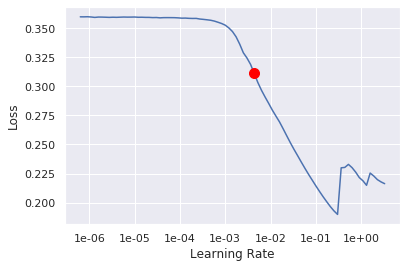

In [308]:
if train_predictor:
    predictor.lr_find()
    predictor.recorder.plot(suggestion=True)

In [317]:
if train_predictor:
    predictor.fit(100, 3.02e-4)

epoch,train_loss,valid_loss,IC50_mse,rescaled_IC50_root_mse,time
0,0.023581,0.024586,0.156798,2.087399,00:06
1,0.023578,0.024590,0.156812,2.087426,00:06
2,0.023689,0.024592,0.156818,2.087265,00:06
3,0.023689,0.024589,0.156809,2.086801,00:06
4,0.023697,0.024584,0.156792,2.086175,00:06
5,0.023697,0.024576,0.156767,2.085419,00:06


tensor([[ 5.2246,  5.8284,  3.5922,  ...,  3.0983,  4.7922,  3.7516],
        [ 3.7905,  5.2981,  2.5174,  ...,  0.8756,  3.3709, -0.3630],
        [ 4.8263,  4.8561,  3.2445,  ...,  1.9370,  3.7323,  1.9749],
        ...,
        [ 5.5043,  5.6587,  4.9729,  ...,  3.7844,  5.1608,  3.5043],
        [ 4.3429,  4.3007,  1.9889,  ..., -2.1872,  2.5997, -3.3017],
        [ 1.3440,  6.1544,  1.4219,  ...,  3.7702,  3.8576,  3.7803]]) tensor([[4.3594, 4.4777, 2.9641,  ..., 1.3641, 3.5914, 1.3823],
        [3.9685, 4.4139, 3.0392,  ..., 1.6268, 4.1564, 1.8441],
        [3.5316, 3.9259, 2.5353,  ..., 0.8687, 2.9963, 0.5914],
        ...,
        [3.6079, 3.9541, 2.5121,  ..., 1.0380, 2.9687, 0.5426],
        [3.2576, 3.9226, 2.4392,  ..., 0.5379, 3.0353, 0.7400],
        [4.5098, 4.5218, 2.9223,  ..., 1.4423, 3.6314, 1.4818]])
tensor([[ 5.2246,  5.8284,  3.5922,  ...,  3.0983,  4.7922,  3.7516],
        [ 3.7905,  5.2981,  2.5174,  ...,  0.8756,  3.3709, -0.3630],
        [ 4.8263,  4.8561,  

In [318]:
val = predictor.validate()[2]
print(val)

tensor(2.0839)


In [319]:
if train_predictor:
    try:
        predictor_fname = f'predictor_loss{predictor.recorder.losses[-1]:.04f}val{val:.04f}'
    except:
        predictor_fname = f'predictor_val{val:.04f}'
    predictor.save(predictor_fname)
    print(predictor_fname)

predictor_loss0.0237val2.0839


In [320]:
try:
    print(f"Attempting to load: {predictor_fname}... ", end="")
    predictor.load(predictor_fname)
    print("Loaded")

except Exception as e:
    print("NOT loaded! ", e)

Attempting to load: predictor_loss0.0237val2.0839... Loaded


In [321]:
p_CCLE_IC50, y_true = predictor.get_preds()

In [322]:
val = predictor.validate()[1]
print(val)

tensor(0.1567)


In [323]:
y_idx = [x.i for x in data_CCLE.valid_ds.x]
y_idx

['NCIH2052',
 'HCC33',
 'SW1573',
 'SNU1',
 'CA46',
 'CHP126',
 'ECC12',
 'JHH7',
 'LOVO',
 'NCIH2452',
 'NCIH1703',
 'SW1783',
 'SNU1040',
 'CAL148',
 'DMS53',
 'UACC812',
 'LN229',
 'MDAMB436',
 'T47D',
 'SAOS2',
 'TE4',
 'BICR31',
 'MOLP8',
 'NCIH1694',
 'RD',
 'HCC70',
 'HCC1937',
 'NCIH1838',
 'HCC2218',
 'CORL88',
 'RL952',
 'FUOV1',
 'SUDHL10',
 'JVM2',
 'SNU81',
 'OE19',
 'NCIH2196',
 'HT144',
 'RERFGC1B',
 'SW1417',
 'NCIH2030',
 'ECGI10',
 'SUPB15',
 'HCT15',
 'RERFLCSQ1',
 'A101D',
 'NCIH929',
 'OSRC2',
 'NCIH209',
 'TALL1',
 'MKN1',
 'A2058',
 'DMS273',
 'DBTRG05MG',
 'PF382',
 'MONOMAC6',
 'HCC44',
 'CL40',
 'NCIH2444',
 'L1236',
 'HS940T']

In [324]:
y_CCLE_IC50 = IC50.reindex(y_idx)
y_CCLE_IC50 = y_CCLE_IC50.transpose()
print(y_CCLE_IC50.shape)


p = p_CCLE_IC50.transpose(1,0)

(265, 61)


Text(0.5, 1, 'predicted CCLE IC50')

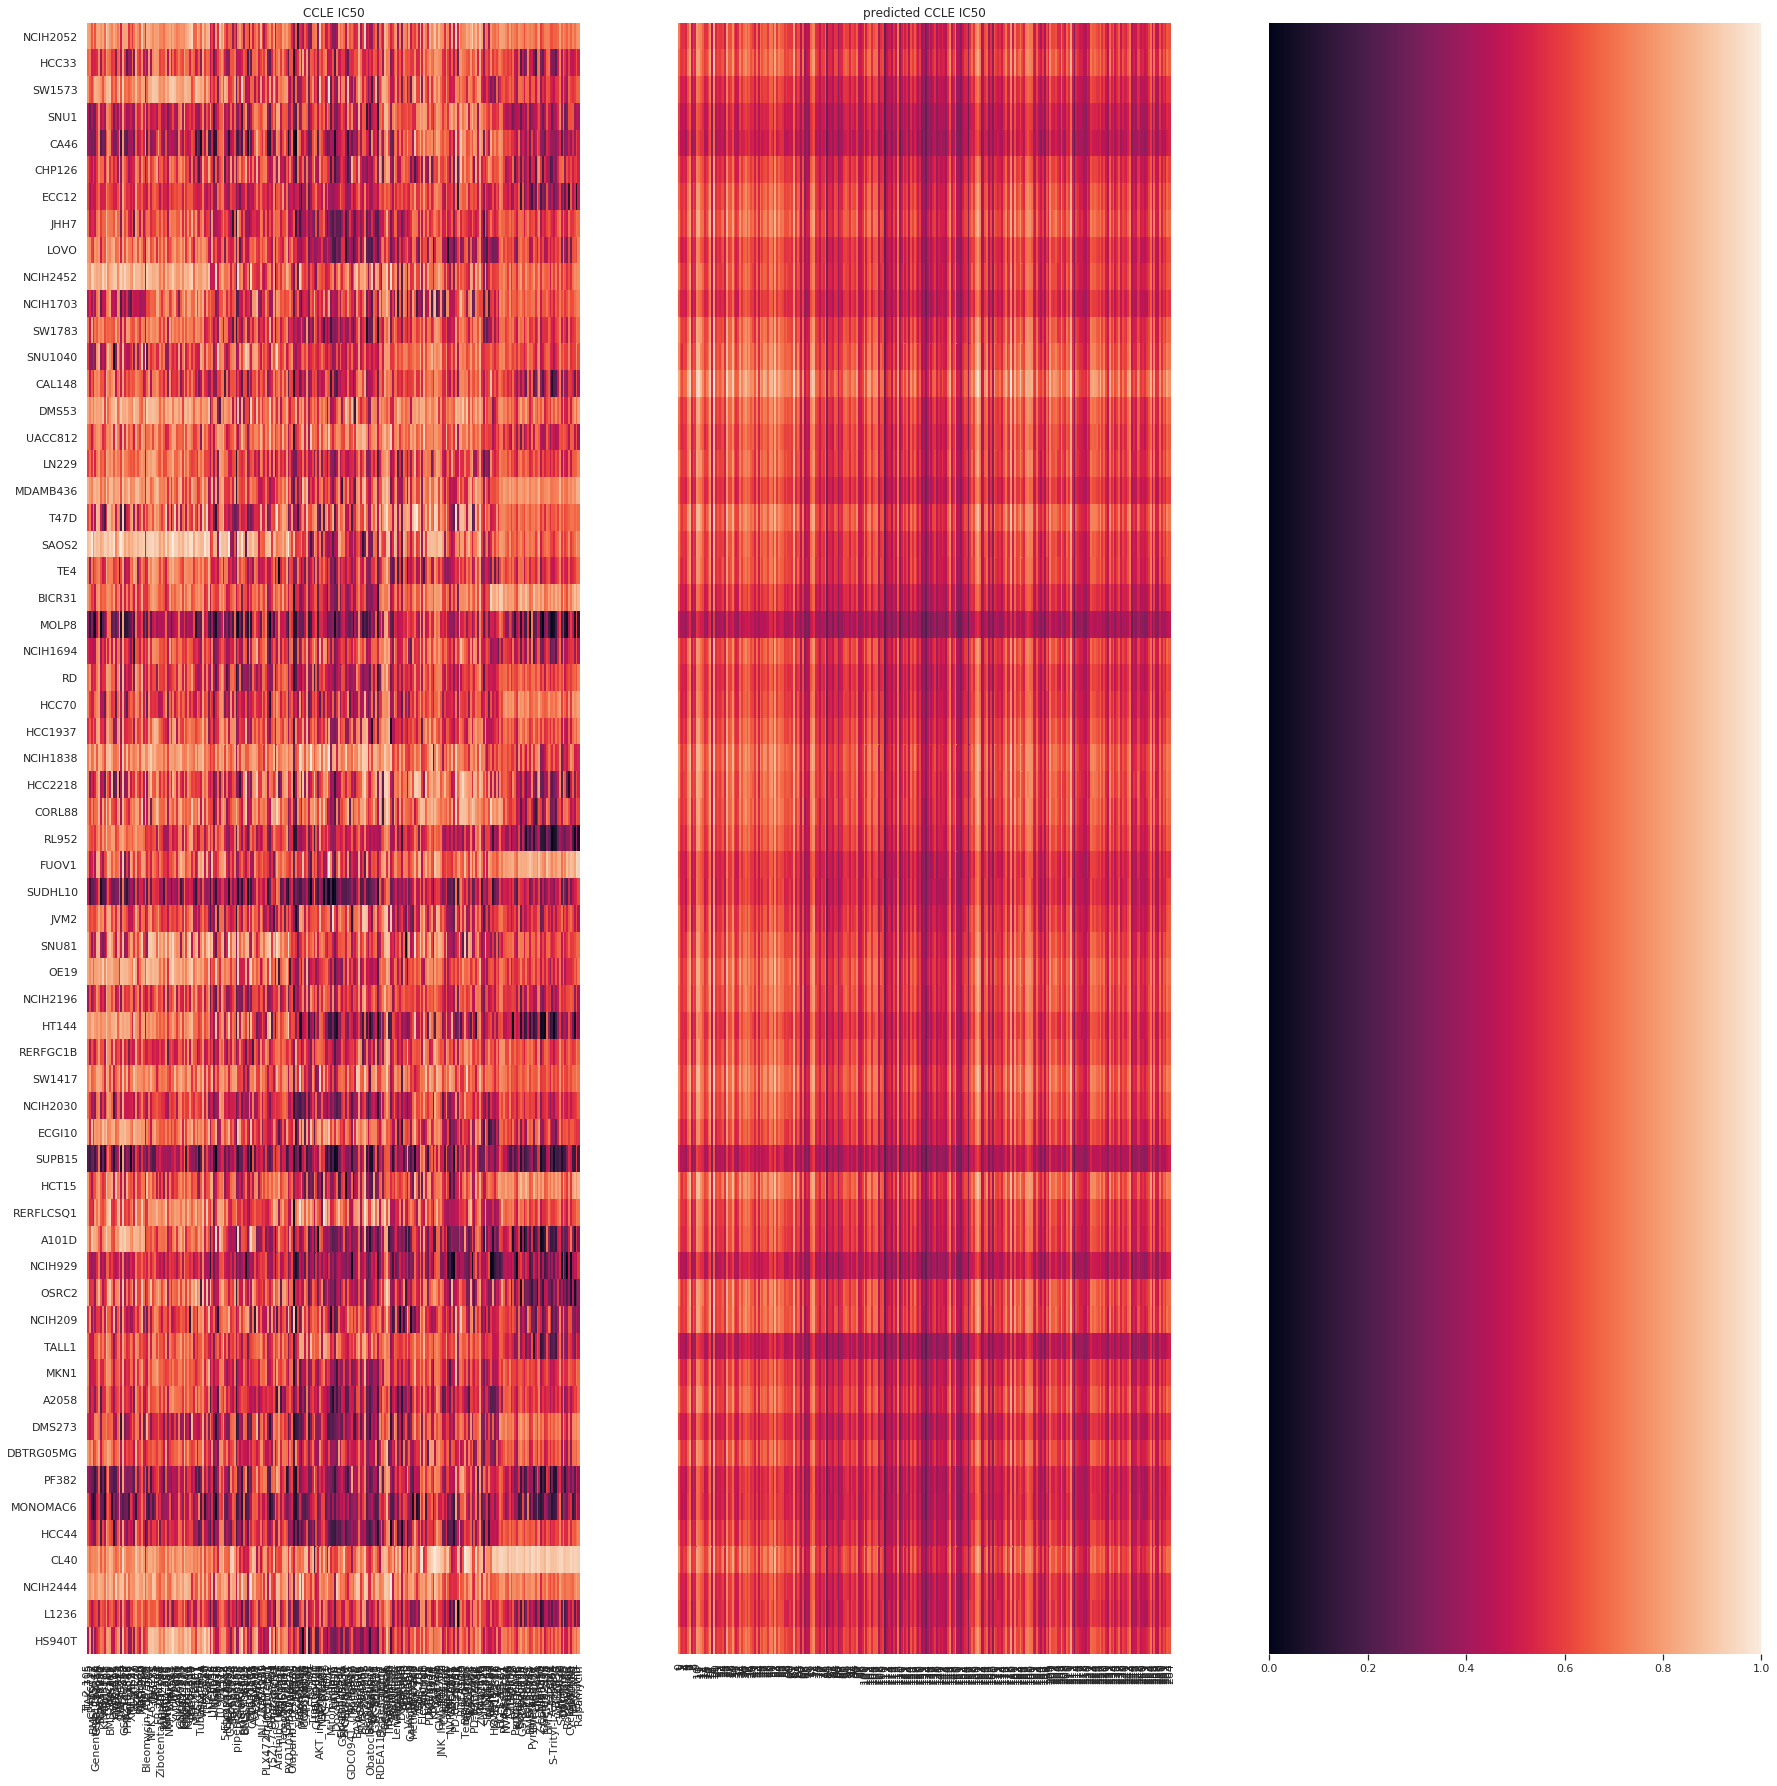

In [325]:
import matplotlib
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(30,30))


_min = IC50.min().min() #-8
_max = IC50.max().max() #12


sns.heatmap(y_CCLE_IC50.transpose(), vmin=_min, vmax=_max, ax = axs[0],cbar=False, xticklabels=True).set_title('CCLE IC50')
sns.heatmap(p.transpose(1,0),  vmin=_min, vmax=_max, ax = axs[1],yticklabels=False, xticklabels=True, cbar_ax = axs[2],cbar_kws={"orientation": "horizontal"} ).set_title('predicted CCLE IC50')


In [224]:
p_valid = IC50_Predictor.predict(X_valid)
y_valid 
p_valid.shape

NameError: name 'IC50_Predictor' is not defined

In [326]:
r = np.corrcoef(p_CCLE_IC50,y_true )
r

array([[1.      , 0.981879, 0.992728, 0.978471, ..., 0.449534, 0.497303, 0.561323, 0.631575],
       [0.981879, 1.      , 0.987594, 0.981598, ..., 0.423977, 0.505584, 0.579225, 0.62701 ],
       [0.992728, 0.987594, 1.      , 0.992006, ..., 0.443891, 0.495896, 0.567567, 0.639079],
       [0.978471, 0.981598, 0.992006, 1.      , ..., 0.427054, 0.476216, 0.559081, 0.635768],
       ...,
       [0.449534, 0.423977, 0.443891, 0.427054, ..., 1.      , 0.272592, 0.074029, 0.274186],
       [0.497303, 0.505584, 0.495896, 0.476216, ..., 0.272592, 1.      , 0.425133, 0.274616],
       [0.561323, 0.579225, 0.567567, 0.559081, ..., 0.074029, 0.425133, 1.      , 0.182138],
       [0.631575, 0.62701 , 0.639079, 0.635768, ..., 0.274186, 0.274616, 0.182138, 1.      ]])

In [327]:
s =  [np.corrcoef(i,j) for i,j in zip(p_CCLE_IC50,y_true) ]

In [328]:
pearsonc = [i[0,1] for i in s]
len(pearsonc)
np.mean(pearsonc)

0.5898090431551979

Text(0.5, 1.0, 'Sample-wise Pearson correlation in log IC50 for CCLE validation sample')

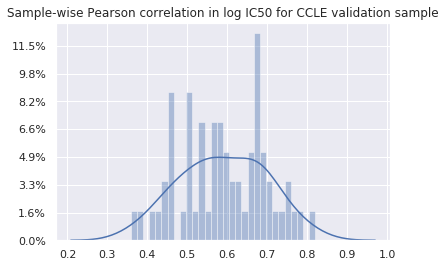

In [329]:
from matplotlib.ticker import PercentFormatter
sns.set();

ax = sns.distplot(pearsonc, bins = 30)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=len(pearsonc)))
ax.set_title('Sample-wise Pearson correlation in log IC50 for CCLE validation sample')

In [ ]:
#Complete architecture
#load pretrained E_M_sco_TCGA encoder
K.clear_session()
gc.collect()

autoencoder = load_model('model_encoder_E_M_sco_TCGA_std.h5', custom_objects={'metric_mse':metric_mse})


In [ ]:
encoder  = autoencoder

In [ ]:
for n in range(5): encoder.layers.pop()
# Check the trainable status of the individual layers
#for layer in encoder:
#    print(layer, layer.trainable)

In [ ]:
encoder.summary()

In [ ]:
n_drugs = IC50.shape[1]
cell_dim = E_M_sco_TCGA_norm.shape[1]
layers = [128,128,128]

# this is our input placeholder
input_cell = Input(shape=(cell_dim,))

x = encoder(input_cell)
use_bn = False
for i,layer in enumerate(layers):
    l = Dense(layer, activation='relu')(x if i == 0 else l)
    if use_bn: l = BatchNormalization()(l)
out = Dense(n_drugs, activation='linear')(l)

In [ ]:
IC50_Predictor = Model(input_cell, out)

In [ ]:
IC50_Predictor.summary()

In [ ]:
callbacks = [keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1),
            keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,verbose=1)]

adam = keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
IC50_Predictor.compile(optimizer= adam, loss='mean_squared_error')

In [ ]:
E_M_sco_CCLE_IC50 = pd.merge(E_M_sco_CCLE_norm,IC50,left_on=E_M_sco_CCLE_norm.index, right_on=IC50.index)

In [ ]:
E_M_sco_CCLE_IC50.shape

In [ ]:
E_M_sco_CCLE_IC50.index =E_M_sco_CCLE_IC50.key_0
E_M_sco_CCLE_IC50.drop(columns='key_0', inplace=True)
E_M_sco_CCLE_IC50.columns

In [ ]:
#reserve a random sample of 20% samples to validate the model
from random import sample 
valid = int(E_M_sco_CCLE_IC50.shape[0]*0.1)
valid_idx = sample(list(E_M_sco_CCLE_IC50.index.values),valid)
x_valid =  E_M_sco_CCLE_IC50.loc[valid_idx, :]
x_train = E_M_sco_CCLE_IC50.drop(valid_idx, axis=0)
print (x_train.shape) 
print (x_valid.shape)
#x_train.describe()

In [ ]:
y_train = x_train.iloc[:,-IC50.shape[1]:]
X_train = x_train.iloc[:,:-IC50.shape[1]]
print(y_train.shape)
print(X_train.shape)
y_valid = x_valid.iloc[:,-IC50.shape[1]:]
X_valid = x_valid.iloc[:,:-IC50.shape[1]]
print(y_valid.shape)
print(X_valid.shape)

In [ ]:
IC50_Predictor.fit(X_train, y_train,
                epochs=100,
                batch_size=100,
                shuffle=True,
                validation_data=(X_valid, y_valid),
                callbacks = callbacks)

In [ ]:
IC50_Predictor.save_weights('IC50_E_M_sco_Predictor_weights.h5')

In [ ]:
IC50_Predictor.load_weights('IC50_E_M_sco_Predictor_weights.h5')

In [ ]:
p = IC50_Predictor.predict(E_M_sco_CCLE_IC50.iloc[:,:-IC50.shape[1]])
p_CCLE_IC50 = p.transpose()

In [ ]:
y_CCLE_IC50 = E_M_sco_CCLE_IC50.iloc[:,-IC50.shape[1]:]
y_CCLE_IC50 = y_CCLE_IC50.transpose()
y_CCLE_IC50.shape

In [ ]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(30,30))

sns.heatmap(y_CCLE_IC50, vmin=-8, vmax=12, ax = axs[0],cbar=False, xticklabels=False).set_title('CCLE IC50')
sns.heatmap(p_CCLE_IC50,  vmin=-8, vmax=12,  ax = axs[1],yticklabels=False, xticklabels=False, cbar_ax = axs[2],cbar_kws={"orientation": "horizontal"} ).set_title('predicted CCLE IC50')


In [ ]:
p_valid = IC50_Predictor.predict(X_valid)
y_valid 
p_valid.shape

In [ ]:
r = np.corrcoef(p_valid[2],y_valid.values[2] )
r

In [ ]:
s =  [np.corrcoef(i,j) for i,j in zip(p_valid,y_valid.values) ]

In [ ]:
pearsonc = [i[0,1] for i in s]
len(pearsonc)
np.mean(pearsonc)

In [ ]:
from matplotlib.ticker import PercentFormatter
sns.set();

ax = sns.distplot(pearsonc, bins = 30)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=len(pearsonc)))
ax.set_title('Sample-wise Pearson correlation in log IC50 for CCLE validation sample')